# CNN for TG Radar spectrogram image classifcation

## T3-2022

### Kussay Al-Zubaidi: ML modelling
### Brandon Low: Data Wrangling and Visualisation 
### Sai Gowtham Reddy Pulagam: Data Wrangling and Visualisation/ ML modelling

In [1]:
import torch 
import torchvision 
import torchvision.transforms as transforms 
from torchvision import datasets 

transform = transforms.Compose( 
    [transforms.Resize((32,32)), # you can change the image size, but need to change the architecture accordingly 
 transforms.ToTensor(), 
 transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))]) 
trainset = datasets.ImageFolder(r'C:\Users\User\Downloads\OneDrive_2022-12-01\Spectrogram_Outputs_small_and_large\train', transform=transform) 

trainloader = torch.utils.data.DataLoader(trainset, 
 batch_size=3, #process only 3 images at a time 
 shuffle=True, num_workers=2) 

testset = datasets.ImageFolder(r'C:\Users\User\Downloads\OneDrive_2022-12-01\Spectrogram_Outputs_small_and_large\test', transform=transform) 

testloader = torch.utils.data.DataLoader(testset, 
 batch_size=3, #process only 3 images at a time 
 shuffle=False, num_workers=2) 

classes = ('sitting', 'standingup', 'walking') 

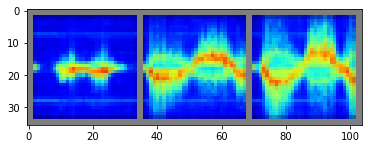

sitting walking walking


In [2]:
import matplotlib.pyplot as plt 
import numpy as np 

# function to show an image 
def imshow(img): 
    img = img / 2 + 0.5 # unnormalize 
    npimg = img.numpy() 
    plt.imshow(np.transpose(npimg, (1, 2, 0))) 
    plt.show() 
    
# get some random training images 
dataiter = iter(trainloader) 
images, labels = dataiter.next() 

# show images 
imshow(torchvision.utils.make_grid(images)) 

# print true labels of the images 
print(' '.join('%5s' % classes[labels[j]] for j in range(3)))

In [3]:
import torch.nn as nn 
import torch.nn.functional as F 
class Net(nn.Module): 
    def __init__(self): 
        super(Net, self).__init__() 
        self.conv1 = nn.Conv2d(3, 6, 5) 
        self.pool = nn.MaxPool2d(2, 2) 
        self.conv2 = nn.Conv2d(6, 16, 5) 
        self.fc1 = nn.Linear(16 * 5 * 5, 120) 
        self.fc2 = nn.Linear(120, 84) 
        self.fc3 = nn.Linear(84, 3) 
    def forward(self, x): 
        x = self.pool(F.relu(self.conv1(x))) #x = self.conv1(x), x = F.relu(x), x = self.pool(x) 
        x = self.pool(F.relu(self.conv2(x))) #x = self.conv2(x), x = F.relu(x), x = self.pool(x) 
        x = x.view(-1, 16 * 5 * 5) #flatten a 16x5x5 tensor to 16x5x5-dimensional vector 
        x = F.relu(self.fc1(x)) 
        x = F.relu(self.fc2(x)) 
        x = self.fc3(x) 
        return x 
net = Net() 

In [4]:
import torch.optim as optim 
criterion = nn.CrossEntropyLoss() 
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)

In [5]:
import time
loss_history = [] 
epoch = 2 
start_time = time.time()
for e in range(epoch): # loop over the dataset multiple times 
    running_loss = 0.0 
    for i, data in enumerate(trainloader, 0): 
# get the inputs; data is a list of [inputs, labels] 
        inputs, labels = data 
# zero the parameter gradients 
        optimizer.zero_grad() 
# forward + backward + optimize 
        outputs = net(inputs) 
        loss = criterion(outputs, labels) 
        loss.backward() 
        optimizer.step() 
# print statistics 
        running_loss += loss.item() 
        if i % 2000 == 1999: # print every 2000 mini-batches 
            print('[%d, %5d] loss: %.3f' % 
            (e + 1, i + 1, running_loss / 2000)) 
            loss_history.append(running_loss) 
            running_loss = 0.0 
print('Finished Training') 
print("Training time in %s seconds ---" % (time.time() - start_time))
#plt.plot(loss_history, label = 'training loss', color = 'r') 
#plt.legend(loc = "upper left") 
#plt.show() 

Finished Training
Training time in 4.6126744747161865 seconds ---


In [6]:
PATH = './cifar_net.pth' 
torch.save(net.state_dict(), PATH)

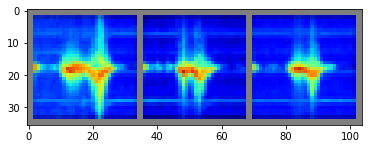

GroundTruth:  sitting sitting sitting


In [7]:
dataiter = iter(testloader) 
images, labels = dataiter.next() 
# print images 
imshow(torchvision.utils.make_grid(images)) 
print('GroundTruth: ', ' '.join('%5s' % classes[labels[j]] for j in range(3)))

In [8]:
#load the trained network 
net = Net() 
net.load_state_dict(torch.load(PATH)) 
outputs = net(images) 

In [9]:
_, predicted_labels = torch.max(outputs, 1) 
print('Predicted: ', ' '.join('%5s' % classes[predicted_labels[j]] 
        for j in range(3)))

Predicted:  walking walking walking


In [10]:
correct = 0 
total = 0 
with torch.no_grad(): 
    for data in testloader: 
        images, groundtruth_labels = data 
        outputs = net(images) 
        _, predicted_labels = torch.max(outputs.data, 1) 
        total += groundtruth_labels.size(0) 
        correct += (predicted_labels == groundtruth_labels).sum().item() 
print('Accuracy of the network on the 10000 test images: %d %%' % (100 * correct / total)) 

Accuracy of the network on the 10000 test images: 33 %


In [11]:
import time
class_correct = list(0. for i in range(3)) 
class_total = list(0. for i in range(3)) 
start_time = time.time()
#the following to help calculate the accuracy and confusion matrix 
predicted_labels_entire=[]
groundtruth_labels_entire=[] 

with torch.no_grad(): 
    for data in testloader: 
        images, groundtruth_labels = data 
        
        groundtruth_labels_entire+=groundtruth_labels
        
        outputs = net(images) 
        _, predicted_labels = torch.max(outputs, 1) 
        
        predicted_labels_entire+=predicted_labels
        
        c = (predicted_labels == groundtruth_labels).squeeze() 
        for i in range(3): 
            label = groundtruth_labels[i] 
            class_correct[label] += c[i].item() 
            class_total[label] += 1 
for i in range(3): 
    print('Accuracy of %5s : %2d %%' % ( 
        classes[i], 100 * class_correct[i] / class_total[i])) 
print("Testing time in %s seconds ---" % (time.time() - start_time))

Accuracy of sitting :  0 %
Accuracy of standingup :  0 %
Accuracy of walking : 100 %
Testing time in 2.4660866260528564 seconds ---


## Confusion Matrix

[[ 0  0 25]
 [ 0  0 25]
 [ 0  0 25]]


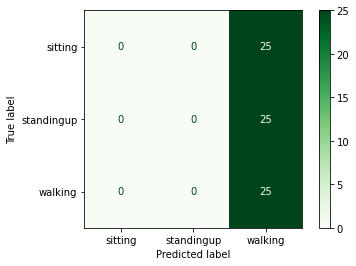

In [12]:
from sklearn.metrics import classification_report,confusion_matrix
cm = confusion_matrix(groundtruth_labels_entire, predicted_labels_entire)
print(cm)

from sklearn import metrics
cm = confusion_matrix(groundtruth_labels_entire, predicted_labels_entire)
    
# Create confusion matrix plot with class label names
confusion_matrix_plot = metrics.ConfusionMatrixDisplay(confusion_matrix = cm,
                                                   display_labels = classes)
    
#Display the confusion matrix plot
confusion_matrix_plot.plot(cmap = plt.cm.Greens)
plt.show()